# EDA
- What is the trend of the stock?

In [3]:
cd ..

/home/jovyan/critical_feature_extraction


In [4]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
%run __init__.py

In [5]:
apple = pd.read_csv("data/sandp500/individual_stocks_5yr_TECHNICALS_clean/AAPL_data.csv")
apple.head()

,Unnamed: 0,Unnamed: 0.1,Date,Open,High,Low,Close,Volume,Name,ADX_14_50,...,RSI_6,RSI_12,STD_5,STD_20,SO%d_5,SO%d_20,SO%k,Trix_5,Trix_20,TSI_25_13
0,61,61,2012-11-09,77.20,79.27,76.25,78.15,232476496,AAPL,0.514584,...,0.038498,0.071578,3.008766,4.566575,0.356641,0.372499,0.629139,-0.011429,-0.003303,-0.371455
1,62,62,2012-11-12,79.16,79.21,76.95,77.55,128950479,AAPL,0.529393,...,0.038498,0.071578,2.558373,4.891156,0.326256,0.362288,0.265487,-0.011652,-0.003535,-0.384467
2,63,63,2012-11-13,76.99,78.64,76.62,77.56,133302610,AAPL,0.543466,...,0.034150,0.067984,1.087000,5.106765,0.372620,0.372120,0.465347,-0.011197,-0.003761,-0.394642
3,64,64,2012-11-14,77.93,78.21,76.60,76.70,119291977,AAPL,0.558600,...,0.033826,0.067740,0.597352,5.257553,0.269117,0.342551,0.062112,-0.010644,-0.003982,-0.406822
4,65,65,2012-11-15,76.79,77.07,74.66,75.09,197477385,AAPL,0.574372,...,0.014778,0.048012,1.191239,5.257375,0.238886,0.326899,0.178423,-0.010561,-0.004207,-0.424001


In [ ]:
apple["Date"] = pd.to_datetime(apple["Date"])
apple =  apple.set_index("Date")
apple = apple.drop("Unnamed: 0", axis = 1)
apple = apple.drop("Unnamed: 0.1", axis = 1)


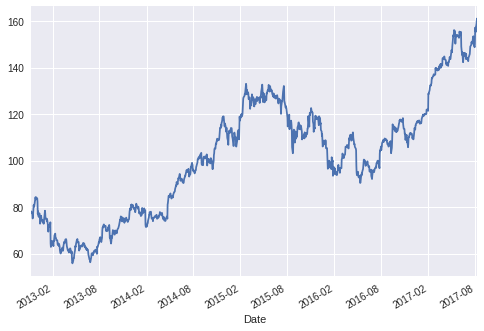

In [7]:
apple["Close"].plot()

Shift technicals down one so "tomorrow"s close can be predicted with yesterday's TIs

In [8]:
apple.iloc[:, 8:] = apple.iloc[:, 8:].shift()

In [16]:
y = apple["Close"]
X = apple.iloc[1:, 6:]

# PCA on TIs

- How many dominant PCs are there?
    - Seems like between 5 and 10

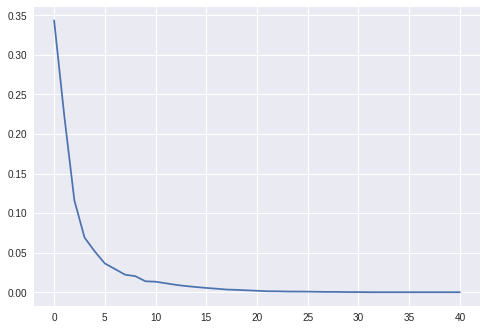

In [17]:
X_standardized = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X_standardized)
plt.plot(pca.explained_variance_ratio_)

Let's take a look at what the first few PCs are composed of. Yellow cells indicate contribution by feature

It would help a lot if I knew what the hell these TIs were

In [18]:
pc_composition = pd.DataFrame(pca.components_[0:5], index = ["PC1", "PC2", "PC3", "PC4", "PC5"], columns = X.columns).T


In [19]:
def highlight_bottom(s):
    '''
    highlight the max and min 3 in a Series yellow.
    '''
    is_blue = s.isin(s.sort_values()[:5])
    return ['background-color: aqua' if v else '' for v in is_blue]


def highlight_top(s):
    '''
    highlight the max and min 3 in a Series yellow.
    '''
    is_red = s.isin(s.sort_values(ascending = False)[:5])
    return ['background-color: crimson' if v else '' for v in is_red]

pc_composition.style.apply(highlight_bottom).apply(highlight_top)

# Baseline predictions

- How well can we predict today's closing price with yesterday's technicals? Which features are influential?

In [20]:
# calculate train split size
2 * apple.shape[0]  / 3

798.0

In [24]:
#chronological train test split

X_train, X_test = apple.iloc[1:796, 6:], apple.iloc[796:, 6:]
y_train, y_test = apple.ix[1:796, "Close"], apple.ix[796:, "Close"]



## Predicting tomorrow with yesterday's value

Before fitting anything let's see what $R^2$ you get by predicting tomorrow with yesterday's value

In [25]:
y_hat_shift = y_test.shift()[1:] 
y_test_shift = y_test[1:]

r2_score(y_hat_shift, y_test_shift)

0.99417257242136758

This is pretty telling. It is not difficult to predict tomorrow's closing price. What you need is to be able to predict far into the future, or this trading signal.

## Random Forest

In [26]:
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
print("Train score:", rf.score(X_train, y_train))
print("Test score:", rf.score(X_test, y_test))

Train score: 0.99909043107
Test score: 0.764380881162


Completely untuned model gets nearly 100% performance on the training set and 76% on the test set. So we have some over-ftting going on.

In [27]:
#technicals associated with closing price
apple.corr()["Close"].abs().sort_values(ascending = False)[4:].head(10)

PP        0.998090
R1        0.997968
S1        0.997959
R2        0.997274
S2        0.997257
EMA_5     0.996784
R3        0.996377
S3        0.996257
MA_5      0.996064
EMA_20    0.990278
Name: Close, dtype: float64

In [29]:
#feature importances
sorted(zip(X.columns, rf.feature_importances_), key = lambda x: abs(x[1]), reverse = True)[:10]

[('PP', 0.29907701936784364),
 ('S1', 0.17542189944001829),
 ('EMA_20', 0.1664778581030211),
 ('MA_20', 0.16484525781936274),
 ('R1', 0.15638237045829584),
 ('EMA_5', 0.014138943726068592),
 ('R3', 0.0083876039738556476),
 ('R2', 0.0072106973563520358),
 ('S2', 0.0031279968583756701),
 ('S3', 0.0014113013531540683)]

Feature importances seem to agree with correlations between Close price and TIs

# Trying out a modeling Pipeline with PCA

In [30]:
rf_pipe_params = {"pca__n_components": np.arange(1,40, 5, dtype = int),
                  "model__n_estimators": [10, 50, 100]}

rf_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA()),
                     ("model", RandomForestRegressor())])



lasso_pipe = Pipeline([("scaler", StandardScaler()),
                     ("pca", PCA()),
                     ("model", Lasso())])

lasso_pipe_params = {"pca__n_components": np.arange(1,40, 5, dtype = int),
                  "model__alpha": np.logspace(-2, 3, 5)}


In [31]:
#Random forest pipeline
rf_gs = GridSearchCV(rf_pipe, rf_pipe_params,
                     cv = 3,
                     verbose = 1)
rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   21.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           m...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 1,  6, 11, 16, 21, 26, 31, 36]), 'model__n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [32]:
rf_gs.best_estimator_.fit(X_train, y_train)
rf_gs.best_estimator_.score(X_test, y_test)

0.69020548552880001

In [33]:
#Lasso pipeline
lasso_gs = GridSearchCV(lasso_pipe, lasso_pipe_params,
                     cv = 3,
                     verbose = 1)

lasso_gs.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': array([ 1,  6, 11, 16, 21, 26, 31, 36]), 'model__alpha': array([  1.00000e-02,   1.77828e-01,   3.16228e+00,   5.62341e+01,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
best_lasso = lasso_gs.best_estimator_

best_lasso.score(X_test, y_test)

0.99314840894635747

# Thoughts & next steps

- Is modelling tomorow's closing price financially valuable? Or do you need to be predicting further into the future? Or predicting a trading signal?
    - I don't think so. Need to move onto deeper predictions, or predicting the trading signal.
- Need to write code for predicting more than one timestep into the future. Do this by iteratively updating TI predictors based on the predictions themselves. How does it do vs ARIMA?
    - Can I assume that being able to train models that predict deep into the future will translate to predicting trading signals?
- Will training on multiple time-series improve performance? Need to write a pipeline to clean and train on multiple stocks at once.
- Is data quality a concern? Do current TI's need to be tuned further? Should We be using other TIs need to refer to literature.
- How do you keep predictor features continually updated as time progresses? Need a pipeline for that